In [1]:
#mounting gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#navigate to the directory
%cd gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs

/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs


In [59]:
#run if required
# !ls
# %autosave 60
# !pip install scikit-learn
# !pip install numpy

In [5]:
# Import required python libraries
from pprint import pprint
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
from geopy.distance import great_circle as vc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as Math
import datetime
import dateutil
import io

In [6]:
# data cleaning/processing: (from hurricane-net, hammad)
db = []
with open('data/hurdat2-1851-2022-050423.txt') as raw: 
    for line in raw: 
        line = line.replace(' ', '').split(',')
    
        # Identify atlantic storm, first 2 letters should be AL
        if (line[0][:2] == 'AL') :
            storm_id = line[0]
            storm_name = line[1]
            storm_entries = line[2]

            # Iterate and read through best track entries
            for i in range(int(storm_entries)) :
                entry = raw.readline().replace(' ', '').split(',')
                # Filter -999 placeholder for missing central pressure
                entry = [None if x == "-999" else x for x in entry]
                # Construct date and time based on first two columns
                timestamp = datetime.datetime(int(entry[0][:4]), int(entry[0][4:6]), int(entry[0][6:8]), int(entry[1][:2]), int(entry[1][3:]))
                # Add entry into our current database
                db.append([storm_id, storm_name, timestamp] + entry[2:-1])
        else :
            print("Error, unidentified storm ".join(str(line[0])))

# Return DataFrame
dataset = pd.DataFrame(db, columns = ['storm_id', 'storm_name', 'entry_time', 'entry_id', 'entry_status', 'lat', 'long','max_wind', 'min_pressure', '34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'])

In [7]:
# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.query('storm_id == "AL122005"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44681,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44682,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44683,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44684,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44685,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


# Transform Data
The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a storm_id dictionary to store storm names matched with ID's

In [7]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add 
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : 980 if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
                'distance': 0,
                'direction': 0
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return


    def update_dist_direc(self):
      t = pd.DataFrame(self.entries.values())
      dst = 0
      prev = (0,0)
      
      # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
      for index,p in enumerate(zip(t['lat'], t['long'])):
          
          if prev == (0,0):
              prev = p
              continue 
          # Stores the distance into the DataFrame
          list(self.entries.values())[index]['distance'] = vc(prev,p).miles
          
          dLon = p[1] - prev[1];  
          temp = float(p[0]) # p[0] is a str?
          y_x = Math.sin(dLon) * Math.cos(temp);
          
          x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
          brng = Math.degrees(Math.atan2(y_x, x_x)) 
          if (brng < 0):
              brng+= 360;
          
          # Stores the angle of travel into the DataFrame
          list(self.entries.values())[index]['direction'] = brng
          # if self.id == 'AL122005' and index==2:
          if self.id == 'AL081994' and index==2:
            print(f'p[1]:{p[1]}')
            print(f'prev[1]:{prev[1]}')
            print(f'dLon:{dLon}')
            print(f'temp:{temp}')
            print(f'y_x:{y_x}')
            print(f'x_x:{x_x}')
            print(f'brng:{brng}')
          dst += vc(prev,p).miles
          prev = p

# Storm ID Key for matching between datasets
storm_ids = dict()
# Parse in hurricanes
hurricanes = dict()

print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming HURDAT2 into objects . . .
Transforming 53976/53976 entries from HURDAT2
Done!


# Load Data
The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [8]:
# add distance and direction attributes to hurricanes
for id in storm_ids :
    hurricanes[id].update_dist_direc()

p[1]:85.9
prev[1]:85.1
dLon:0.8000000000000114
temp:16.5
y_x:-0.5038688074294795
x_x:-0.09353734284162374
brng:259.4834249123352


In [9]:
#will test distance and direction of the bulk update vs individual update
t=pd.DataFrame(hurricanes['AL081994'].entries.values())
t['dist']=0
t['direc']=0

In [10]:
#testing for one hurricane
prev=(0,0)
for index,p in enumerate(zip(t['lat'], t['long'])):
  if prev == (0,0):
    prev = p
    print(f'index:{index},prev:{prev}')
    continue 
  # Stores the distance into the DataFrame
  t.at[index,'dist'] = vc(prev,p).miles

  dLon = p[1] - prev[1];  
  temp = float(p[0]) # p[0] is a str?
  y_x = Math.sin(dLon) * Math.cos(temp);

  x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
  brng = Math.degrees(Math.atan2(y_x, x_x)) 
  if (brng < 0):
    brng+= 360;
  t.at[index,'direc'] = brng
  if index==2:
    print(f'p[1]:{p[1]}')
    print(f'prev[1]:{prev[1]}')
    print(f'dLon:{dLon}')
    print(f'temp:{temp}')
    print(f'y_x:{y_x}')
    print(f'x_x:{x_x}')
    print(f'brng:{brng}')
  print(index,t.at[index,'direc'])
  prev = p

index:0,prev:(16.0, 84.5)
1 306.71943856277255
p[1]:85.9
prev[1]:85.1
dLon:0.8000000000000114
temp:16.5
y_x:-0.5038688074294795
x_x:-0.09353734284162374
brng:259.4834249123352
2 259.4834249123352
3 214.6478709156233
4 205.37541693715318
5 220.82857383503298
6 226.7059563604921
7 284.9406861076747
8 332.53635339353264
9 342.17177270335054


In [11]:
t #to check that distance calculation and direction calculation from bulk vs individual

,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,wind_radii,distance,direction,dist,direc
0,1994-09-24 12:00:00,,TD,16.0,84.5,25.0,1008.0,34kt_ne None 34kt_se None 34kt_sw Non...,0.000000,0.000000,0.000000,0.000000
1,1994-09-24 18:00:00,,TD,16.3,85.1,30.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,44.891903,306.719439,44.891903,306.719439
2,1994-09-25 00:00:00,,TD,16.5,85.9,30.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,54.796781,259.483425,54.796781,259.483425
3,1994-09-25 06:00:00,,TD,16.6,86.7,30.0,1006.0,34kt_ne None 34kt_se None 34kt_sw Non...,53.433344,214.647871,53.433344,214.647871
4,1994-09-25 12:00:00,,TD,16.7,87.6,30.0,1005.0,34kt_ne None 34kt_se None 34kt_sw Non...,59.976134,205.375417,59.976134,205.375417
5,1994-09-25 18:00:00,L,TD,16.6,88.4,30.0,1004.0,34kt_ne None 34kt_se None 34kt_sw Non...,53.406014,220.828574,53.406014,220.828574
6,1994-09-26 00:00:00,,TD,16.6,88.7,30.0,1006.0,34kt_ne None 34kt_se None 34kt_sw Non...,19.864134,226.705956,19.864134,226.705956
7,1994-09-26 06:00:00,,TD,16.6,88.9,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,13.242757,284.940686,13.242757,284.940686
8,1994-09-26 12:00:00,,TD,16.5,89.2,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,21.036343,332.536353,21.036343,332.536353
9,1994-09-26 18:00:00,,TD,16.5,89.5,25.0,1007.0,34kt_ne None 34kt_se None 34kt_sw Non...,19.874439,342.171773,19.874439,342.171773


# Feature Engineering & Data Augmentation
The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.
1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [12]:
#feature extraction
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    
    timestep = {
      'lat' : float,
      'long' : float,
      'max-wind' : float,
      'entry-time' : datetime
    }
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
        'delta_pressure': (timestep['min_pressure'] - previous['min_pressure']) /
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'distance': timestep['distance'],
        'direction': timestep['direction']
    }
    return features

# def extract_test_dataset(features):
#     df = pd.DataFrame(features)
#     df_test = df[df['year']==2022]
#     df_train_val = df[df['year']!=2022]
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # x_test = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    # y_test = dict([(time,[]) for time in times])
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        test_sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            # if feature_extraction(timestep, previous)['year']!=2022:
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
            # if feature_extraction(timestep, previous)['year']==2022:
            #   test_sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
              # print(test_sample)
            
            # print('sample')
            # print(sample)
        # print('test_sample')
        # print(len(test_sample), len(sample))
        x.append(sample) # Add our constructed sample
        # x_test.append(test_sample)
        # print(x_test[0])
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            # if feature_extraction(timestep, previous)['year']==2022:
              # if timestep and previous: 
              #   y_test[future].append(feature_extraction(timestep, previous))
              # else: 
              #   y_test[future].append(None)
            # else:
            if timestep and previous:
              y[future].append(feature_extraction(timestep, previous))
            else :
              y[future].append(None)
    # print(f'type of x:{x_test[:10]}')
    # Return output, if there is no output, return None.
    if len(x) == 0 :
        return None
    else:
        # print(f'x:{x}')
        # return {'x': x, 'x_test': x_test, 'y': y, 'y_test': y_test}
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    # x_test = []
    y = []
    # y_test = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        # print('result')
        # print(result)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        # if count==10:
          # print(f'hurricane_x:{hurricane_x}')
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # hurricane_x_test = np.array(
        #     [[list(sample[1][0].values()) for sample in x_test] for x_test in result['x_test']],
        #     dtype = precision)
        # # if count==10:
        #   # print(f'hurricane_x:{hurricane_x}')
        # hurricane_y_test = np.array(
        #     [[list(result['y_test'][time][index].values()) for time in times] for index in range(len(result['y_test'][lag]))],
        #     dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
            # if (len(np.where(np.isnan(hurricane_x_test))[0]) > 0) or (len(np.where(np.isnan(hurricane_y_test))[0]) > 0) :
            #     continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        # x_test.extend(hurricane_x_test)
        # y_test.extend(hurricane_y_test)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    # print(x_test[0])
    # return {'x': np.array(x), 'y': np.array(y), 'x_test': np.array(x_test), 'y_test': np.array(y_test)}
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    # print(x.shape)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    # print(x.shape)
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    # x_test = np.reshape(unqiue_data['x_test'], (unqiue_data['x_test'].shape[0], -1))
    # print('x_test')
    # print(x_test[:10])
    # x_test = np.delete(x_test, np.where(np.isnan(x_test))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    # scaler.fit(x_test)
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
        # Scale our x_test
        # processed_data['x_test'][index] = scaler.transform(processed_data['x_test'][index])
        # Scale our y_test
        # processed_data['y_test'][index] = scaler.transform(processed_data['y_test'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1944/1952 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1952/1952 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


# Model Architecture
Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

Notes:

1.   We will use 500 epochs for wind intensity because the validation loss is not decreasing
2.   We will use 1,000 epochs for latitute and longitude

In [13]:
#import python librairies for deep learning architecture
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection
import pickle

In [14]:
# Create our cross validation data structure
X_train, X_rem, y_train, y_rem = model_selection.train_test_split(processed_data['x'], processed_data['y'], train_size=0.8)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_rem,y_rem, test_size=0.5)

In [15]:
#Bidirectional LSTM with Stochastic gradient descent optimizer
def bd_lstm_sgd(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.15),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    # model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.15)))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.15))
    # model.add(TimeDistributed(Dense(1)))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='sgd')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

In [16]:
#Bidirectional LSTM with RMSprop optimizer
def bd_lstm_rmsprop(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.2),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.2))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='rmsprop')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

In [17]:
#Bidirectional LSTM with Adadelta optimizer
def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adadelta')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

In [18]:
# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)

# Train for min pressure
y_train_pressure = np.array([[[features[4]] for features in y] for y in y_train], dtype = np.float64)
y_test_pressure = np.array([[[features[4]] for features in y] for y in y_test], dtype = np.float64)

# Train for direction
y_train_direction = np.array([[[features[13]] for features in y] for y in y_train], dtype = np.float64)
y_test_direction = np.array([[[features[13]] for features in y] for y in y_test], dtype = np.float64)


# Train for distance
y_train_distance = np.array([[[features[12]] for features in y] for y in y_train], dtype = np.float64)
y_test_distance = np.array([[[features[12]] for features in y] for y in y_test], dtype = np.float64)

In [ ]:
# model_wind_rmsprop, model_wind_history_rmsprop = bd_lstm_rmsprop(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)
# model_lat_rmsprop, model_lat_history_rmsprop = bd_lstm_rmsprop(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 500)
# model_long_rmsprop, model_long_history_rmsprop = bd_lstm_rmsprop(X_train, y_train_long, X_test, y_test_long, n_epochs = 500)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 5, 256)            1311744   
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 7s 7s/step - loss: 0.6191 - val_loss: 0.9618
Epoch 2/500
1/1 [==============================] - 0s 420ms/step - loss: 0.

In [ ]:
# pickle.dump(model_wind_rmsprop,open('model_wind_rmsprop.pkl','wb'))
# pickle.dump(model_wind_history_rmsprop,open('model_wind_history_rmsprop.pkl','wb'))
# pickle.dump(model_lat_rmsprop,open('model_lat_rmsprop.pkl','wb'))
# pickle.dump(model_lat_history_rmsprop,open('model_lat_history_rmsprop.pkl','wb'))
# pickle.dump(model_long_rmsprop,open('model_long_rmsprop.pkl','wb'))
# pickle.dump(model_long_history_rmsprop,open('model_long_history_rmsprop.pkl','wb'))

In [19]:
import pickle
model_wind_history_rmsprop = pickle.load(open('model_wind_history_rmsprop.pkl', 'rb'))
model_lat_history_rmsprop = pickle.load(open('model_lat_history_rmsprop.pkl', 'rb'))
model_long_history_rmsprop = pickle.load(open('model_long_history_rmsprop.pkl', 'rb'))

In [20]:
model_wind_rmsprop = pickle.load(open('model_wind_rmsprop.pkl','rb'))
model_lat_rmsprop = pickle.load(open('model_lat_rmsprop.pkl','rb'))
model_long_rmsprop = pickle.load(open('model_long_rmsprop.pkl','rb'))

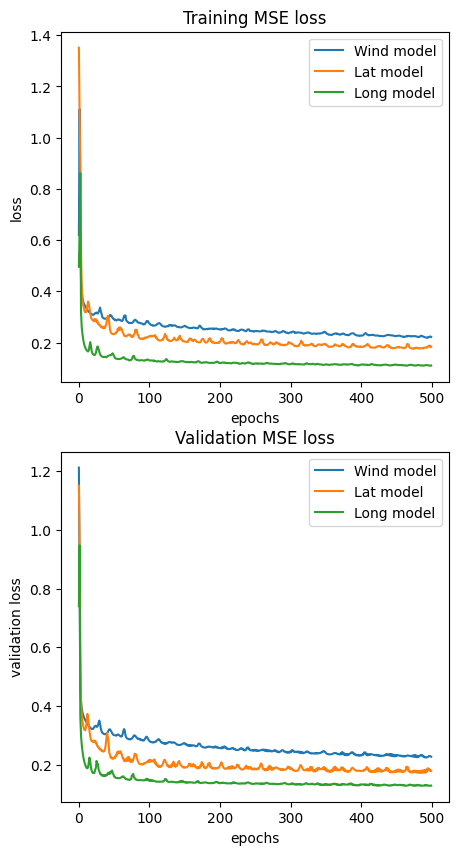

In [21]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1, figsize=(5,10))
axs[0].plot(range(500),model_wind_history_rmsprop.history['loss'], label='Wind model') 
axs[0].plot(range(500),model_lat_history_rmsprop.history['loss'], label='Lat model')
axs[0].plot(range(500),model_long_history_rmsprop.history['loss'], label='Long model') 
axs[1].plot(range(500), model_wind_history_rmsprop.history['val_loss'], label='Wind model')
axs[1].plot(range(500), model_lat_history_rmsprop.history['val_loss'], label='Lat model')
axs[1].plot(range(500), model_long_history_rmsprop.history['val_loss'], label='Long model')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[0].set_title('Training MSE loss')
axs[1].set_title('Validation MSE loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epochs')
axs[1].set_ylabel('validation loss')
axs[1].set_xlabel('epochs')
plt.show()

In [ ]:
model_wind_sgd, model_wind_history_sgd = bd_lstm_sgd(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)
model_lat_sgd, model_lat_history_sgd = bd_lstm_sgd(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 500)
model_long_sgd, model_long_history_sgd = bd_lstm_sgd(X_train, y_train_long, X_test, y_test_long, n_epochs = 500)

In [ ]:
model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)
model_lat, model_lat_history = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 500)
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long, n_epochs = 500)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_13 (LSTM)              (None, 5, 256)            1311744   
                                                                 
 time_distributed_6 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 0.6293 - val_loss: 0.6220
Epoch 2/500
1/1 [==============================] - 0s 464ms/step - loss: 0.

In [22]:
# def ai_errors(predictions, observations, history = None) :
#     '''
#     PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
#     METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
#     INPUT:   predictions - 2D array of predictions of observed output
#              observations - 2D array measurements of observed output
#              history - Keras history model for displaying model loss, default is None if not available
#     OUTPUT:
#     '''
#     errors = []
#     for i in range(len(predictions)) :
#         for j in range(len(predictions[i])) :
#             # Calculate errors
#             error = predictions[i][j] - observations[i][j]
#             errors.append(error)
    
#     # Display history and erros
#     # plt.figure(1)
#     # plt.hist(errors, bins = 50)
#     # plt.title('error histogram')
#     # plt.xlabel('error')
#     # plt.ylabel('frequency')
#     # plt.grid(True)
    
#     # plt.figure(2)
#     # plt.plot(history.history['loss'])
#     # plt.plot(history.history['val_loss'])
#     # plt.title('model loss')
#     # plt.ylabel('loss')
#     # plt.xlabel('epoch')
#     # plt.legend(['train', 'test'], loc='upper left')
#     # plt.show()
    
#     return pd.DataFrame(errors)

In [23]:
#Predict values
wind_predictions = model_wind_rmsprop.predict(X_test)
lat_predictions = model_lat_rmsprop.predict(X_test)
long_predictions = model_long_rmsprop.predict(X_test)
# pressure_predictions = model_pressure.predict(X_test)
# # Scale back our predictions
# # Wind
wind_predictions_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

# Pressure
# pressure_predictions_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0,0,0] for pressure in prediction])
#                            for prediction in pressure_predictions]
# y_pressure_test_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0,0,0] for pressure in observation])
#                       for observation in y_test_pressure]

42/42 [==============================] - 1s 3ms/step


In [24]:
# # Record wind predictions and observations
from sklearn.metrics import mean_squared_error
print("Wind")
wind_predictions = [[pred[2] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[2] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]
wind_test_error = mean_squared_error(wind_observations, wind_predictions)
wind_predictions
# # Present Errors
# ai_errors(wind_predictions, wind_observations, model_wind_history_rmsprop).describe()

Wind


[[117.23373889923096,
  110.89434623718262,
  100.06170749664307,
  89.73805665969849,
  80.80070972442627],
 [48.52207750082016,
  45.02443164587021,
  40.35666584968567,
  37.72542595863342,
  35.426448583602905],
 [24.970500469207764,
  26.527104377746582,
  32.7215051651001,
  38.460683822631836,
  40.57506799697876],
 [63.54991436004639,
  59.639429450035095,
  52.709864377975464,
  47.272116243839264,
  42.617740631103516],
 [35.23969292640686,
  38.59241843223572,
  41.86554431915283,
  43.04142653942108,
  42.46657729148865],
 [76.7576003074646,
  67.32600212097168,
  55.51570534706116,
  45.563898384571075,
  38.186001777648926],
 [45.35483807325363,
  54.424860179424286,
  59.956817626953125,
  63.032681941986084,
  62.81922936439514],
 [88.7917685508728,
  79.05312538146973,
  69.20151948928833,
  62.95720338821411,
  57.54199802875519],
 [79.43050861358643,
  72.10700988769531,
  61.81312918663025,
  52.936336398124695,
  45.866176784038544],
 [44.8309451341629,
  49.228103

In [25]:
dataset.query('storm_name == "ANDREW"').head()

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
36303,AL011986,ANDREW,1986-06-05 00:00:00,,SD,26.2N,75.8W,30,1007,None,...,None,None,None,None,None,None,None,None,None,None
36304,AL011986,ANDREW,1986-06-05 06:00:00,,SD,27.4N,76.0W,30,1006,None,...,None,None,None,None,None,None,None,None,None,None
36305,AL011986,ANDREW,1986-06-05 12:00:00,,SD,28.4N,76.4W,30,1005,None,...,None,None,None,None,None,None,None,None,None,None
36306,AL011986,ANDREW,1986-06-05 18:00:00,,SD,29.1N,77.0W,30,1003,None,...,None,None,None,None,None,None,None,None,None,None
36307,AL011986,ANDREW,1986-06-06 00:00:00,,TS,29.7N,77.5W,35,1002,None,...,None,None,None,None,None,None,None,None,None,None


In [26]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
# ai_errors(lat_predictions, lat_observations, model_lat_history_rmsprop)

Lat


In [27]:
print("Long")
long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
# ai_errors(long_predictions, long_observations, model_long_history).describe()

Long


In [ ]:
# print("Pressure")
# pressure_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in pressure_predictions_scaled]
# pressure_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_pressure_test_scaled]
# ai_errors(pressure_predictions, pressure_observations, model_pressure_history).describe()

In [ ]:
# print("Distance")
# distance_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in distance_predictions_scaled]
# distance_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_distance_test_scaled]
# ai_errors(distance_predictions, distance_observations, model_distance_history).describe()

In [61]:
# !pip install BaseMap
# from mpl_toolkits.basemap import Basemap
# def returnBaseMap(map_region):
#     '''
#     input:
#         map_region: a list for basemap, [lat_0,lon_0,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat]
#                     lat_0,lon_0,llcrnrlon for center of map
#                     llcrnrlon,llcrnrlat for lower left corner
#                     urcrnrlon,urcrnrlat for upper right corner
#                     longitudes and latitudes in degree, negative for 'W'
#                     small_area = [25,-40,-90,0,-20,50] for a smaller region
#                     large_area = [25,-60,-105,0,20,60] for a larger region for all hurricanes
#     return:
#         a base map to be ploted on. 
#     '''
#     lat_0,lon_0,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat = map_region
#     fig = plt.figure(figsize=(12,12),dpi=150)
#     map2 = Basemap(projection='lcc', lat_0=lat_0, lon_0=lon_0, 
#                    llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
#                    urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, 
#                    lat_1=33, lat_2=45, resolution='l', area_thresh=1000.0) # 
#     map2.drawcoastlines()  
#     map2.fillcontinents(color='lightgray') #,lake_color='aqua'
    
#     map2.drawmeridians(np.arange(0, 360, 10),labels=[False,False,False,True])#label longitudes
#     map2.drawparallels(np.arange(-90, 90, 10),labels=[True,True,False,True]) #label latitudes
    
#     return map2

# def plotPathOnMap(mylon,mylat,color,aBaseMap,label=None,linewidth=0.5):
#     '''
#     This func is used to plot a path given longitudes and latitudes on given base map.
#     input:
#         mylon: a list of longitudes, floats
#         mylat: a list of latitudes, floats
#         color: color for the path
#         aBaseMap: a map returned from returnBaseMap
#     return:
#         a map with plotted paths.
#     '''
#     # plot a path with given latitudes and logitudes
#     aBaseMap.plot(mylon, mylat, linewidth=linewidth, label=label,color=color,latlon='True') 
#     return aBaseMap




In [60]:
# '''
# 'AL122005', 'Katrina' - has 34 records with 3 landfalling, or 28 sequences
# 'AL011986', 'Andrew'  - has 16 record with 0 landfalling, or 13 sequences
# 'AL091969', 'Camille' - has 37 records with 2 landfalling, or 32 sequences.
# M2o model has same number of predictions as the number of sequences.
# if the number of sequences of a hurricane is greater than the batch size, modify
# this section.
# the first 3 records of each hurricane will be IGNORED since M2O3 has NO predictions.
# '''

# plot_list = ['AL122005', 'AL011986','AL091969' ]
# name_list = ['Katrina','Andrew','Camille']
# for aHurricaneIdentifier, aHurricaneName in zip(plot_list,name_list):
#     aHurricane = dataset.loc[dataset['storm_id']==aHurricaneIdentifier]
#     large_area = [25,-60,-105,0,20,60] #for a larger region for all hurricanes
#     aBaseMap = returnBaseMap(large_area)
#     aBaseMap = plotPathOnMap(list(long_observations),list(lat_observations),'b',aBaseMap,label='True',linewidth=2)
#     aBaseMap = plotPathOnMap(list(long_predictions),list(lat_predictions),'r',aBaseMap,label='Predicted',linewidth=2)
#     plt.legend(loc=4)
#     plt.title('Path Prediction for ' + aHurricaneIdentifier+', '+ aHurricaneName)
#     file_name = 'bidirectional_LSTM_path_'+aHurricaneName+'.png'
#     plt.savefig(file_name,dpi=300)
#     plt.show()

Model Evaluation

In [30]:
test_data = [] # data cleaning/processing: (from hurricane-net, hammad)
db = []
with open('data/hurdat2-1851-2022-050423.txt') as raw: 
    for line in raw: 
        line = line.replace(' ', '').split(',')
    
        # Identify atlantic storm, first 2 letters should be AL
        if (line[0][:2] == 'AL') :
            storm_id = line[0]
            storm_name = line[1]
            storm_entries = line[2]

            # Iterate and read through best track entries
            for i in range(int(storm_entries)) :
                entry = raw.readline().replace(' ', '').split(',')
                # Filter -999 placeholder for missing central pressure
                entry = [None if x == "-999" else x for x in entry]
                # Construct date and time based on first two columns
                timestamp = datetime.datetime(int(entry[0][:4]), int(entry[0][4:6]), int(entry[0][6:8]), int(entry[1][:2]), int(entry[1][3:]))
                # Add entry into our current database
                db.append([storm_id, storm_name, timestamp] + entry[2:-1])
        else :
            print("Error, unidentified storm ".join(str(line[0])))

# Return DataFrame
test_data = pd.DataFrame(db, columns = ['storm_id', 'storm_name', 'entry_time', 'entry_id', 'entry_status', 'lat', 'long','max_wind', 'min_pressure', '34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'])

In [36]:
desired_years = [1969, 1986, 2005]

# Parse in hurricanes
hurricanes_target = dict()
print("Transforming 2005, 1986, 1969 HURDAT2 into objects . . .")
for index, entry in test_data.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset)), end = "\r")
    # Filter to capture 2017 data
    # if int(entry['storm_id'][-4:]) not in desired_years:
    if entry['storm_name'] not in ['ANDREW','KATRINA','CAMILLE']:
        continue
    if entry['storm_id'] not in hurricanes_target:
        hurricanes_target[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes_target[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming 2005, 1986, 1969 HURDAT2 into objects . . .
Transforming 53976/53976 entries from HURDAT2
Done!


In [49]:
hurricanes_target.keys()
#dict_keys(['AL091969', 'AL211981', 'AL011986', 'AL041992', 'AL151999', 'AL122005'])

dict_keys(['AL091969', 'AL211981', 'AL011986', 'AL041992', 'AL151999', 'AL122005'])

In [51]:
test_data.query('storm_name == "KATRINA"')

,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
35166,AL211981,KATRINA,1981-11-03 00:00:00,,TD,16.9N,81.2W,25,1005,None,...,None,None,None,None,None,None,None,None,None,None
35167,AL211981,KATRINA,1981-11-03 06:00:00,,TD,17.2N,81.3W,25,1005,None,...,None,None,None,None,None,None,None,None,None,None
35168,AL211981,KATRINA,1981-11-03 12:00:00,,TD,17.5N,81.4W,25,1004,None,...,None,None,None,None,None,None,None,None,None,None
35169,AL211981,KATRINA,1981-11-03 18:00:00,,TD,17.8N,81.4W,30,1002,None,...,None,None,None,None,None,None,None,None,None,None
35170,AL211981,KATRINA,1981-11-04 00:00:00,,TD,18.1N,81.4W,30,1001,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44710,AL122005,KATRINA,2005-08-30 06:00:00,,TS,34.1N,88.6W,40,978,75,...,75,50,0,0,0,0,0,0,0,0
44711,AL122005,KATRINA,2005-08-30 12:00:00,,TD,35.6N,88.0W,30,985,0,...,0,0,0,0,0,0,0,0,0,0
44712,AL122005,KATRINA,2005-08-30 18:00:00,,TD,37.0N,87.0W,30,990,0,...,0,0,0,0,0,0,0,0,0,0
44713,AL122005,KATRINA,2005-08-31 00:00:00,,EX,38.6N,85.3W,30,994,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Filter storms that have more than 6 entries. We need at least 6 to calculate 5 speed vectors
storms_filter = [storm for storm in hurricanes_target.values() if len(storm.entries) > 6]

# Begin creating hurricane forecast and track predictions
tracks = {
    'storms' : [], # Reference storm
    'inputs' : [], # The inputs for the ai
    'valid_times' : [], # The valid time to compare to the error database
}
for index, storm in enumerate(storms_filter) :
    # Create inputs to ai. ai requires scaled data as input
    entries = [entry[1] for entry in sorted(storm.entries.items())] # Extracts data from data structure
    
    # Scale the entries
    for start_index in range(1, len(entries) - 5) : # Go through each entry
        # Build feature extraction
        extracted_features = []
        valid_time = None # Going to be set to the last element in the series
        for pivot in range(start_index, start_index + 5) :
            extracted_features.append(np.array(list(feature_extraction(entries[pivot], entries[pivot - 1]).values())))
            if pivot is start_index + 4 : # We're on the last element
                valid_time = entries[pivot]['entry_time']
        
        # If there's an incomplete value we can't process, skip it
        if any(None in entry for entry in extracted_features) :
            continue
            
        # Scale extracted features        
        scaled_entries = scaler.transform(extracted_features)
        
        # Add to our results
        tracks['storms'].append(storm)
        tracks['inputs'].append(scaled_entries.tolist())
        tracks['valid_times'].append(valid_time)
        
    print("\rDone with track processing {}/{} storms".format(index + 1, len(storms_filter)), end = '')
tracks['inputs'] = np.array(tracks['inputs'])

Done with track processing 6/6 storms

In [39]:
# Define a function to return the distance between two coordinates in nautical miles
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d * 0.539957 # km to nautical miles

In [41]:
tracks['inputs'].shape

(139, 5, 14)

In [44]:
tracks['wind_predictions_raw'] = model_wind_rmsprop.predict(tracks['inputs'])
tracks['lat_predictions_raw'] = model_lat_rmsprop.predict(tracks['inputs'])
tracks['long_predictions_raw'] = model_long_rmsprop.predict(tracks['inputs'])

5/5 [==============================] - 0s 4ms/step


In [46]:
tracks['wind_predictions_raw'].shape

(139, 5, 1)

In [47]:
# Scale back and store our wind predictions and our lat, long predictions
tracks['wind_predictions'] = []
tracks['lat_predictions'] = []
tracks['long_predictions'] = []
intensity_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
track_errors = {
    '24' : [],
    '48' : [],
    '72' : [],
    '96' : [],
    '120' : []
}
for index, prediction in enumerate(tracks['wind_predictions_raw']) :
    # Use our standard scaler to scale the raw predictions back
    winds_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0,0,0] for winds in prediction])] # Index 2 is winds
    lat_scaled = [scaler.inverse_transform([[lats[0],0,0,0,0,0,0,0,0,0,0,0,0,0] for lats in tracks['lat_predictions_raw'][index]])] # Index 0 is lat
    long_scaled = [scaler.inverse_transform([[0,longs[0],0,0,0,0,0,0,0,0,0,0,0,0] for longs in tracks['long_predictions_raw'][index]])] # Index 1 is long
    
    # Extract the wind prediction from data structure and store into new data structure
    for i in range(len(winds_scaled)) :        
        # The new data structure is a tuple of (wind, storm_id, valid_time, forecast_time)
        wind_predictions = []
        lat_predictions = []
        long_predictions = []
        for step, pred in enumerate(winds_scaled[i]) :
            wind = pred[2]
            lat = lat_scaled[i][step][0]
            long_1 = long_scaled[i][step][1]
            
            storm_id = tracks['storms'][index].id
            valid_time = tracks['valid_times'][index]
            forecast_time = valid_time + datetime.timedelta(days = step + 1)
            
            # See if we can find the error
            if forecast_time in hurricanes_target[storm_id].entries :
                wind_truth = hurricanes_target[storm_id].entries[forecast_time]['max_wind']
                lat_truth = hurricanes_target[storm_id].entries[forecast_time]['lat']
                long_truth = hurricanes_target[storm_id].entries[forecast_time]['long']
                intensity_error = abs(wind_truth - wind)
                track_error = distance((lat_truth,long_truth), (lat, long_1))
                
                wind_predictions.append({
                    'ai-wind' : wind,
                    'truth' : wind_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                lat_predictions.append({
                    'ai-lat' : lat,
                    'truth' : lat_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                long_predictions.append({
                    'ai-long' : long_1,
                    'truth' : long_truth,
                    'storm_id' : storm_id,
                    'valid_time' : valid_time,
                    'forecast_time' : forecast_time
                })
                if step == 0 :
                    intensity_errors['24'].append(intensity_error)
                    track_errors['24'].append(track_error)
                if step == 1 :
                    intensity_errors['48'].append(intensity_error)
                    track_errors['48'].append(track_error)
                if step == 2 :
                    intensity_errors['72'].append(intensity_error)
                    track_errors['72'].append(track_error)
                if step == 3 :
                    intensity_errors['96'].append(intensity_error)
                    track_errors['96'].append(track_error)
                if step == 4 :
                    intensity_errors['120'].append(intensity_error)
                    track_errors['120'].append(track_error)
                    
        tracks['wind_predictions'].append(wind_predictions)
        tracks['lat_predictions'].append(lat_predictions)
        tracks['long_predictions'].append(long_predictions)

In [52]:
# Compare predictions when we can find them
katrina_pred = {
    'latitude': [],
    'longitude': []
}
katrina_real = {
    'latitude': [],
    'longitude': []
}
andrew_pred = {
    'latitude': [],
    'longitude': []
}
andrew_real = {
    'latitude': [],
    'longitude': []
}
camille_pred = {
    'latitude': [],
    'longitude': []
}
camille_real = {
    'latitude': [],
    'longitude': []
}

ai_wind_errors = []
ai_track_errors = []
for index, prediction in enumerate(tracks['wind_predictions']) :
    # Find the time stamp for the storm ID in the error database
    if prediction == [] :
      continue
    valid_time = prediction[0]['valid_time']
    storm_id = prediction[0]['storm_id']
    if(storm_id != 'AL011986' and storm_id != 'AL122005' and storm_id != 'AL091969'):
      continue
    print(valid_time)
    # If we find it, compare
    for i, forecast in enumerate(prediction) :
        print("\tIntensity Truth: {}, AI forecast: {}".format(forecast['truth'], forecast['ai-wind']))
        print("\tTrajectory Truth: {}, {}; AI forecast: {}, {} ; AI error: {}".format(tracks['lat_predictions'][index][i]['truth'],
                                                                                                tracks['long_predictions'][index][i]['truth'],
                                                                                                tracks['lat_predictions'][index][i]['ai-lat'],
                                                                                                tracks['long_predictions'][index][i]['ai-long'],
                                                                                                distance((tracks['lat_predictions'][index][i]['truth'], tracks['long_predictions'][index][i]['truth']), (tracks['lat_predictions'][index][i]['ai-lat'], tracks['long_predictions'][index][i]['ai-long'])),))
        print()
        if storm_id == 'AL122005':
          katrina_pred['latitude'].append(tracks['lat_predictions'][index][i]['ai-lat'])
          katrina_pred['longitude'].append(tracks['long_predictions'][index][i]['ai-long'])
          katrina_real['latitude'].append(tracks['lat_predictions'][index][i]['truth'])
          katrina_real['longitude'].append(tracks['long_predictions'][index][i]['truth'])
        if storm_id == 'AL091969':
          camille_pred['latitude'].append(tracks['lat_predictions'][index][i]['ai-lat'])
          camille_pred['longitude'].append(tracks['long_predictions'][index][i]['ai-long'])
          camille_real['latitude'].append(tracks['lat_predictions'][index][i]['truth'])
          camille_real['longitude'].append(tracks['long_predictions'][index][i]['truth'])
        if storm_id == 'AL011986':
          andrew_pred['latitude'].append(tracks['lat_predictions'][index][i]['ai-lat'])
          andrew_pred['longitude'].append(tracks['long_predictions'][index][i]['ai-long'])
          andrew_real['latitude'].append(tracks['lat_predictions'][index][i]['truth'])
          andrew_real['longitude'].append(tracks['long_predictions'][index][i]['truth'])
        ai_wind_errors.append(abs(forecast['truth'] - forecast['ai-wind']))
        ai_track_errors.append(abs(distance((tracks['lat_predictions'][index][i]['truth'], tracks['long_predictions'][index][i]['truth']), (tracks['lat_predictions'][index][i]['ai-lat'], tracks['long_predictions'][index][i]['ai-long']))))

1969-08-15 06:00:00
	Intensity Truth: 105.0, AI forecast: 80.62334537506104
	Trajectory Truth: 23.1, 85.2; AI forecast: 21.088863486051558, 84.03214996457099 ; AI error: 137.11596677046916

	Intensity Truth: 145.0, AI forecast: 88.20374727249146
	Trajectory Truth: 26.0, 87.7; AI forecast: 23.053768396377563, 88.30922077298163 ; AI error: 179.9949254235534

	Intensity Truth: 115.0, AI forecast: 83.3823823928833
	Trajectory Truth: 30.7, 89.6; AI forecast: 25.828561210632323, 89.54151753187179 ; AI error: 292.49985019678746

	Intensity Truth: 30.0, AI forecast: 76.49352073669434
	Trajectory Truth: 36.0, 89.3; AI forecast: 28.689730167388916, 90.4857219338417 ; AI error: 443.0016436644525

	Intensity Truth: 25.0, AI forecast: 64.07847046852112
	Trajectory Truth: 37.4, 80.6; AI forecast: 32.8892261505127, 89.4823687672615 ; AI error: 512.976456489415

1969-08-15 12:00:00
	Intensity Truth: 130.0, AI forecast: 91.05671405792236
	Trajectory Truth: 23.8, 86.0; AI forecast: 22.067312240600586, 8

In [63]:
# !pip install --no-binary shapely shapely --force
# !pip install cartopy

In [55]:
# Plotting hurricane katrina
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_trajectory(real_latitudes, real_longitudes, predicted_latitudes, predicted_longitudes): 
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

  # Plot the real trajectory
  ax.plot(real_longitudes, real_latitudes, marker='o', transform=ccrs.Geodetic(), color='blue', label='Real')

  # Plot the predicted trajectory
  ax.plot(predicted_longitudes, predicted_latitudes, marker='o', transform=ccrs.Geodetic(), color='red', label='Predicted')

  ax.set_extent([min(real_longitudes + predicted_longitudes) - 1, max(real_longitudes + predicted_longitudes) + 1,
                min(real_latitudes + predicted_latitudes) - 1, max(real_latitudes + predicted_latitudes) + 1],
                crs=ccrs.PlateCarree())
  ax.set_title('Trajectory Comparison')
  ax.legend()

  ax.coastlines(resolution='10m')
  ax.gridlines(draw_labels=True)#, linestyle='--')
  # Uncomment the line below if you want to add a background image
  # ax.stock_img()

  plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


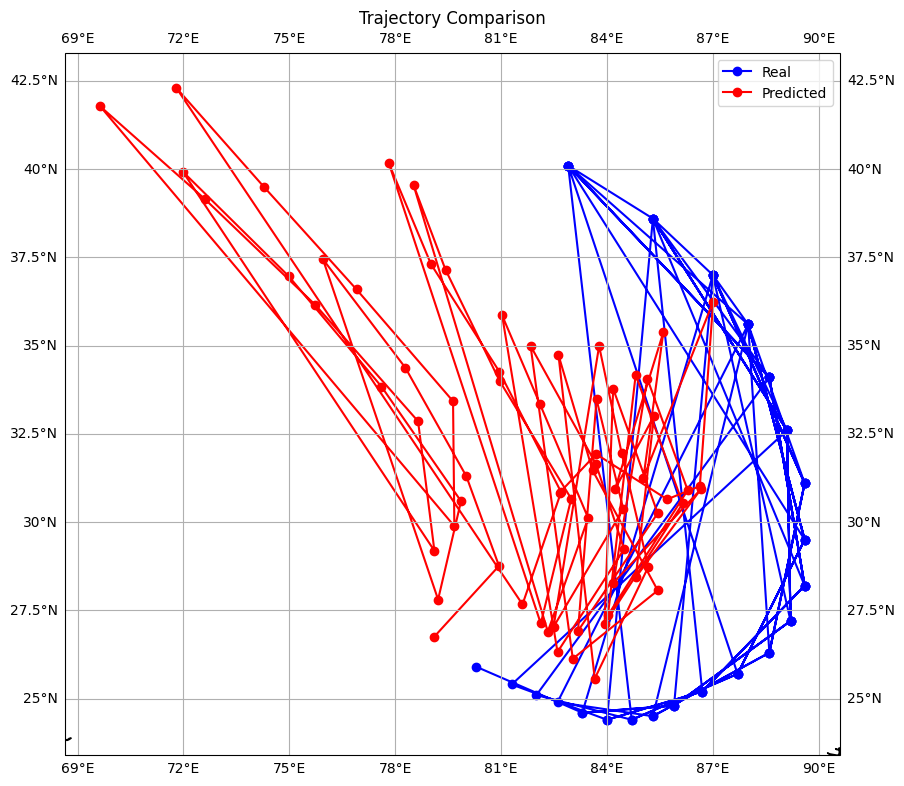

In [56]:
plot_trajectory(katrina_real['latitude'], katrina_real['longitude'], katrina_pred['latitude'], katrina_pred['longitude'])

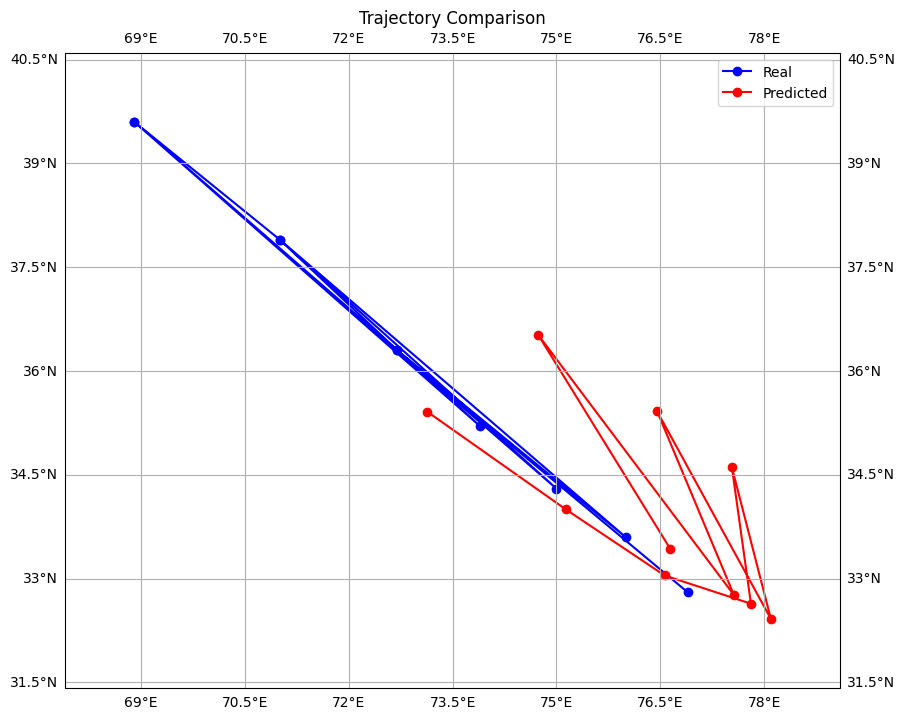

In [57]:
plot_trajectory(andrew_real['latitude'], andrew_real['longitude'], andrew_pred['latitude'], andrew_pred['longitude'])

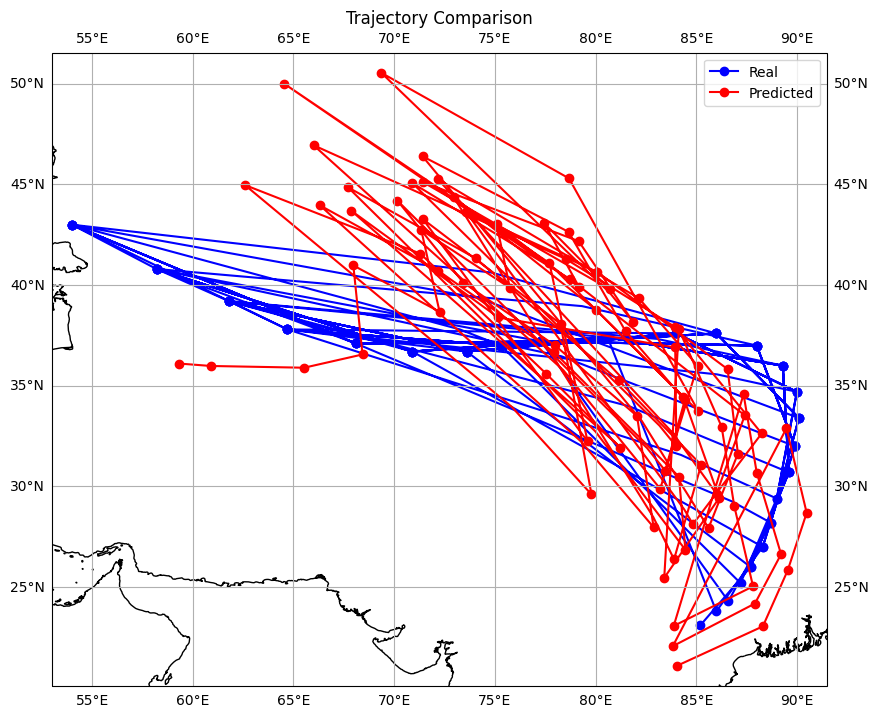

In [58]:
plot_trajectory(camille_real['latitude'], camille_real['longitude'], camille_pred['latitude'], camille_pred['longitude'])